# Fitting notebook

In [1]:
%reload_ext autoreload
%autoreload 2

import eos
import eos.plot

import numpy as np
import scipy as sp
import warnings
import json
from pathlib import Path
import os
import corner
from publik.reweight import corner_cls
from publik.reweight import plot


import matplotlib
matplotlib.style.use(Path('../style.mplstyle'))
import matplotlib.pyplot as plt
# plt.rcParams["pgf.texsystem"] = ("pdflatex")
matplotlib.rcParams["text.usetex"] = False

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
cv = r'$C_{VL}^{NP} + C_{VR}$'
cs = r'$C_{SL} + C_{SR}$'
ct = r'$C_{TL}$'
labels = [cv, cs, ct]

cVLSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

bins = 71

## Frequentist -- $CL_s$

### hypotest.py

Compute $CL_s$ value for 1d and 2d grids in WC space, profiling over the rest. 

In [3]:
def load_results(results, fitdir):
    try:
        file = np.load(fitdir / 'results.npz')
        if len(file[file.files[0]]) == len(list(fitdir.glob('*.json'))) and np.array_equal(np.sort(file.files), np.sort(list(results.keys()))):
                for k in results.keys():
                    results[k] = file[k]
        else:
            raise ValueError
    except:
        for filename in fitdir.glob('*.json'):
            try:
                file = json.load(open(filename))
                for k in results.keys():
                    if k == 'wilsons':
                        model = np.full(3, np.nan)
                        for kk,vv in file['model'].items():
                            if kk == 'cvl': model[0] = vv
                            if kk == 'csl': model[1] = vv
                            if kk == 'ctl': model[2] = vv
                        results[k].append(model)
                    else:
                        results[k].append(file[k])
            except:
                raise ValueError("something wrong with: " + str(filename))
            
    for k,v in results.items():
        results[k] = np.array(v)

In [4]:
# get cls, sig
FITDIR = Path('../results/fit/hypo_profiled_wide/')

results_cls = { 'wilsons' : [],
                'cls_obs' : [],
                'cls_exp' : [],
                'tail_probs' : [],
                'qmu' : [],
                'qmuA' : [],
                }
    
load_results(results_cls, FITDIR)
        
len(results_cls['wilsons'])

15336

In [5]:
np.savez(FITDIR / 'results.npz', 
         wilsons    = results_cls['wilsons'],
         cls_obs    = results_cls['cls_obs'],
         cls_exp    = results_cls['cls_exp'],
         tail_probs = results_cls['tail_probs'],
         qmu        = results_cls['qmu'],
         qmuA       = results_cls['qmuA']
         )

In [6]:
# plt.scatter(wilsons_cls[:,1], wilsons_cls[:,2], c='r', marker='.')
# plt.gca().set_aspect('equal')

In [39]:
file = '../results/fit/WCscan/cls_corner.pdf'

fig = corner_cls.corner(
            results_cls['wilsons'], 
            bins=bins, 
            weights=results_cls['cls_obs'], 
            levels=(0.68, 0.95), 
            levels_1d=(0.95,), 
            # quantiles=(0.16, 0.84), 
            range = [(-35, 35) for _ in range(3)],
            smooth=1,
            labels=labels,
            color='#D81B60',
            max_n_ticks_y=5,
            y_label=r'$CL_S$',
            density=False
);
plot.b2_logo(ax=fig.axes[1], x=0.6,  fontsize=20)

corner_cls.overplot_lines(fig, [-cVLSM,None, None], color="g", linestyle='dotted', label=r'$-C_{VL}^{SM}$')

handles, labs = fig.axes[0].get_legend_handles_labels()
by_label = dict(zip(labs, handles))
fig.legend(by_label.values(), by_label.keys())

plt.savefig(file)  
plt.show()

In [40]:
file = '../results/fit/WCscan/cls_psb_corner.pdf'

fig = corner_cls.corner(
            results_cls['wilsons'], 
            bins=bins, 
            weights=results_cls['tail_probs'][:,0], 
            levels=(0.68, 0.95), 
            # quantiles=(0.16, 0.84), 
            range = [(-35, 35) for _ in range(3)],
            smooth=1,
            labels=labels,
            color='#D81B60',
            density=False,
            y_label=r'$P_{s+b}$',
            max_n_ticks_y=5,
);
# plot.b2_logo(ax=fig.axes[2], fontsize=20)

corner_cls.overplot_lines(fig, [-cVLSM,None, None], color="g", linestyle='dotted', label=r'$-C_{VL}^{SM}$')

handles, labs = fig.axes[0].get_legend_handles_labels()
by_label = dict(zip(labs, handles))
fig.legend(by_label.values(), by_label.keys())

plt.savefig(file)  
plt.show()

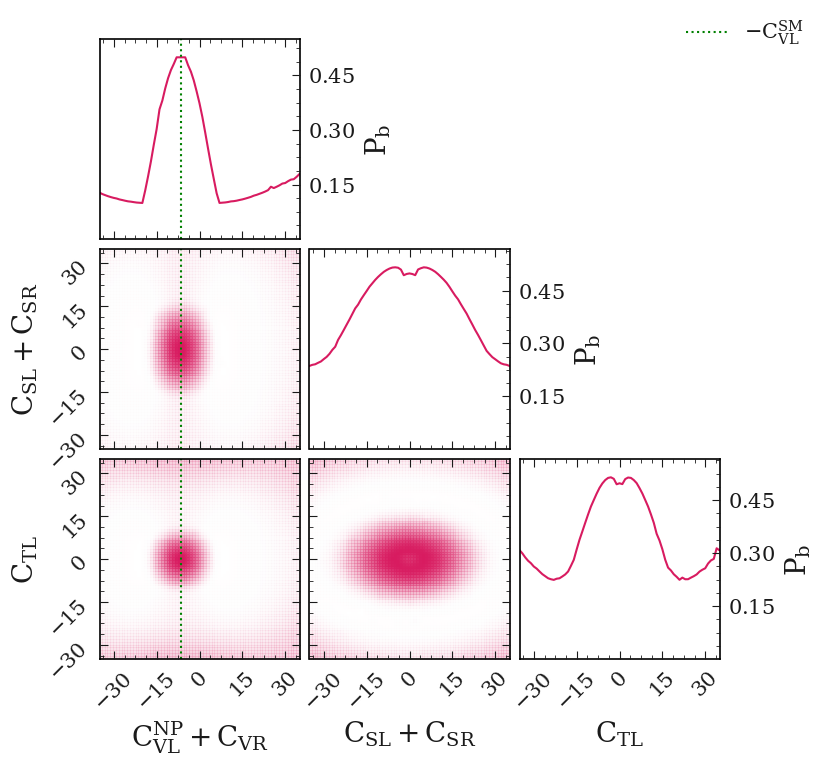

In [41]:
file = '../results/fit/WCscan/cls_pb_corner.pdf'

fig = corner_cls.corner(
            results_cls['wilsons'], 
            bins=bins, 
            weights=1-results_cls['tail_probs'][:,1], 
            levels=(0.95,), 
            # quantiles=(0.16, 0.84), 
            range = [(-35, 35) for _ in range(3)],
            smooth=1,
            labels=labels,
            color='#D81B60',
            density=False,
            y_label=r'$P_{b}$',
            max_n_ticks_y=5,
);
# plot.b2_logo(ax=fig.axes[2], fontsize=20)

corner_cls.overplot_lines(fig, [-cVLSM,None, None], color="g", linestyle='dotted', label=r'$-C_{VL}^{SM}$')

handles, labs = fig.axes[0].get_legend_handles_labels()
by_label = dict(zip(labs, handles))
fig.legend(by_label.values(), by_label.keys())

plt.savefig(file)  
plt.show()

### Limits

cvl [-20.49554603  20.59253572]
csl [-29.27998837  29.22754057]
ctl [-19.37829732  19.35441864]


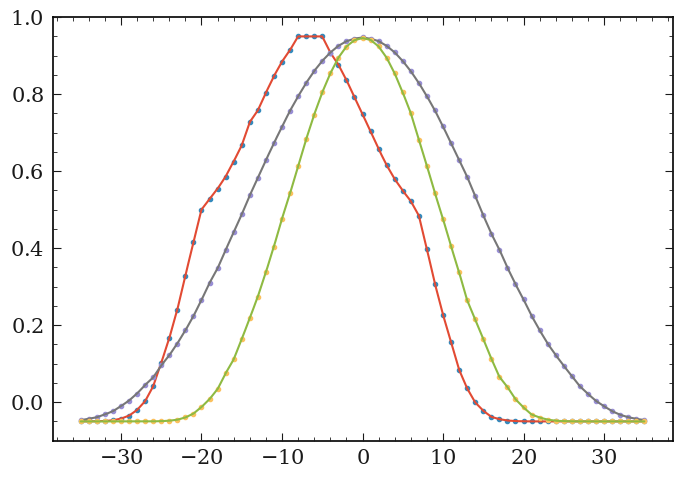

In [10]:
import eos

def get_1d_cls(coeff, results):
    if coeff == 'cvl': 
        i = 0
    elif coeff == 'csl': 
        i = 1
    elif coeff == 'ctl': 
        i = 2
    else: 
        raise ValueError('Invalid coefficient')
    
    cond = np.invert(np.isnan(results_cls['wilsons'][:,i])) & np.isnan(results_cls['wilsons'][:,(i+1)%3]) & np.isnan(results_cls['wilsons'][:,(i+2)%3])
    
    wil = results['wilsons'][cond][:,i]
    cls = results['cls_obs'][cond]
    
    return wil, cls

def find_limit(wilson, cls, limit=0.05):
    order = np.argsort(wilson)

    wilson = wilson[order]
    cls = cls[order]

    spl = sp.interpolate.interp1d(wilson, cls)

    low = sp.optimize.root_scalar(lambda x: spl(x)-limit, bracket = (min(wilson), 0)).root
    hig = sp.optimize.root_scalar(lambda x: spl(x)-limit, bracket = (0, max(wilson))).root
    
    x=np.linspace(-35, 35, 1000)
    plt.plot(wilson, cls-0.05, '.')
    plt.plot(x, spl(x)-0.05)
    
    return np.array([low, hig])

for c in ['cvl', 'csl', 'ctl']:
    wil, cls = get_1d_cls(c, results_cls)
    if c == 'cvl': 
        sm = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()
        print(c, find_limit(wil, cls)+sm)
    else:
        print(c, find_limit(wil, cls))

## Bayesian

### bayesian_wcs.py

Sample in WC space and use likelihood as sample weight.

In [11]:
def load_results(results, fitdir):
    try:
        file = np.load(fitdir / 'results.npz')
        if len(file[file.files[0]]) == len(list(fitdir.glob('*.json'))) and np.array_equal(np.sort(file.files), np.sort(list(results.keys()))):
                for k in results.keys():
                    results[k] = file[k]
        else:
            raise ValueError
    except:
        for filename in fitdir.glob('*.json'):
            try:
                file = json.load(open(filename))
                for k in results.keys():
                    if k == 'wilsons':
                        results[k].append([file['fit_values']['cvl'][0], file['fit_values']['csl'][0], file['fit_values']['ctl'][0]])
                    else:
                        results[k].append(file[k])
            except:
                raise ValueError("something wrong with: " + str(filename))
            
        for k,v in results.items():
            results[k] = np.array(v)
    

In [12]:
# get nll
FITDIR = Path('../results/fit/bayesian_wcs_wide/')

results = { 'wilsons' : [],
            'twice_nll' : [],
            }
load_results(results, FITDIR)

len(results['wilsons'])

30000

In [13]:
np.savez(FITDIR / 'results.npz', 
         wilsons    = results['wilsons'],
         twice_nll  = results['twice_nll'],
         )

In [14]:
# nll_norm = nll - min(nll) + 1
ll_norm = np.exp(-0.5*(results['twice_nll'] - min(results['twice_nll'])))
print(min(ll_norm), max(ll_norm))

2.2851292993276683e-101 1.0


/nfs/dust/belle1/user/lorenzg/venv_naf_publik/lib/python3.8/site-packages/eos/plot/plotter.py:2087: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


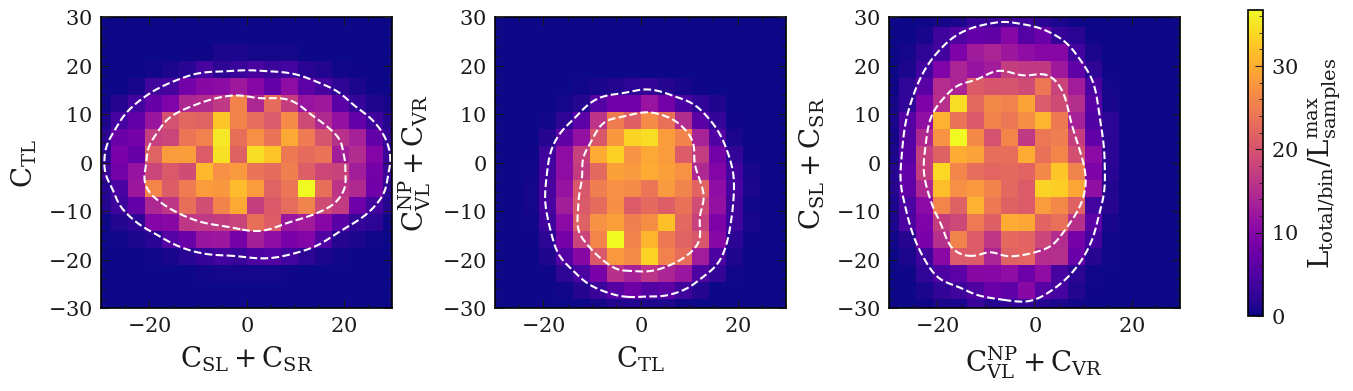

In [15]:
file = '../results/fit/WCscan/bayesian.pdf'

fig, ax = plt.subplots(1,3,figsize=(15,5), constrained_layout=True)
parlabel = r'$L_{total/bin}/L^{max}_{samples}$'
cv = r'$C_{VL}^{NP} + C_{VR}$'
cs = r'$C_{SL} + C_{SR}$'
ct = r'$C_{TL}$'
labels = [cv, cs, ct]

for i in range(3):
    hist = ax[i].hist2d(results['wilsons'][:,(i+1)%3], results['wilsons'][:,(i+2)%3], bins=(20,20), weights=ll_norm, cmap='plasma')
    plot_args = {
                'axis': ax[i],
                'plot': {
                   'x': { 'label': labels[(i+1)%3], 'range': [-30,30] },
                   'y': { 'label': labels[(i+2)%3], 'range': [-30,30] },
                },
                'contents': [
                   {
                       'type': 'kde2D', 'color': 'C1', 'label': 'posterior',
                       'levels': [68, 95], 'contours': ['lines'], 'bandwidth':1.,
                       'data': { 'samples': results['wilsons'][:, ((i+1)%3,(i+2)%3)], 'weights':ll_norm }
                   }
                ]
           }
    eos.plot.Plotter(plot_args).plot()

    ax[i].set_xlabel(labels[(i+1)%3])
    ax[i].set_ylabel(labels[(i+2)%3])
    
    #remove watermark for now because tex rendering causes errors
    ax[i].texts[0].remove()
    
    # change contour line style and color
    ax[i].collections[1].set(edgecolor='white', linestyle="dashed")
    ax[i].collections[2].set(edgecolor='white', linestyle="dashed")
    
    ax[i].set_box_aspect(1)
    
    # if contours:shrink=0.65
    #     opt = dict(levels=contours, colors=["white"])
    #     ax[i].tricontour(x, y, z, linestyles="dashed", **opt)
    # ax[i].scatter(x, y, c=z, marker='.', edgecolor="tan", cmap="plasma")

fig.colorbar(hist[3], ax=ax.ravel().tolist(), shrink=0.85, label=parlabel)

plt.savefig(file)  
plt.show()


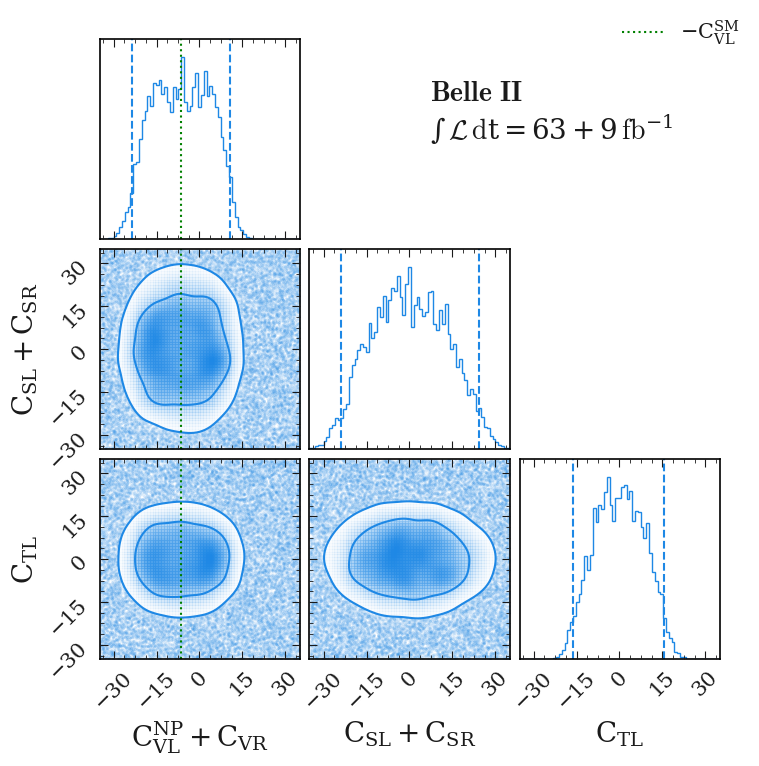

In [43]:
cv = r'$C_{VL}^{NP} + C_{VR}$'
cs = r'$C_{SL} + C_{SR}$'
ct = r'$C_{TL}$'
labels = [cv, cs, ct]

file = '../results/fit/WCscan/bayesian_corner.pdf'

fig = corner.corner(results['wilsons'], 
              bins=71, 
              weights=ll_norm/sum(ll_norm), 
              levels=(0.68, 0.95), 
              quantiles=(0.025, 0.975), 
              smooth=3,
              labels=labels,
              color='#1E88E5',
              );
plot.b2_logo(ax=fig.axes[1], x=0.6, fontsize=20)
corner.overplot_lines(fig, [-cVLSM,None, None], color="g", linestyle='dotted', label=r'$-C_{VL}^{SM}$')

handles, labs = fig.axes[0].get_legend_handles_labels()
by_label = dict(zip(labs, handles))
fig.legend(by_label.values(), by_label.keys())

# fig.legend()

plt.savefig(file)  
plt.show()

## Calculate exclusion limits

In [17]:
from scipy.stats import gaussian_kde
i=1
lims = [-30,30]
samples = results['wilsons'][:, ((i+1)%3,(i+2)%3)].T

kde = gaussian_kde(samples, weights=ll_norm)
kde.set_bandwidth(bw_method='silverman')

xx, yy = np.mgrid[lims[0]:lims[1]:100j, lims[0]:lims[1]:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
pdf = np.reshape(kde(positions).T, xx.shape)
pdf /= pdf.sum()

# find the PDF value corresponding to a given cummulative probability
plevel = lambda x, pdf, P: pdf[pdf > x].sum() - P
plevels = []
for level in [95]:
    plevels.append(sp.optimize.brentq(plevel, 0., 1., args=(pdf, level / 100.0)))
    print(f'For {level/100} weight inclusion:')
    print(f'x_min: {min(xx[pdf>=plevels[-1]])}, x_max: {max(xx[pdf>=plevels[-1]])}')
    print(f'y_min: {min(yy[pdf>=plevels[-1]])}, x_max: {max(yy[pdf>=plevels[-1]])}')



For 0.95 weight inclusion:
x_min: -19.09090909090909, x_max: 19.090909090909093
y_min: -27.575757575757574, x_max: 14.848484848484851


## Compare to frequentist to Bayesian method

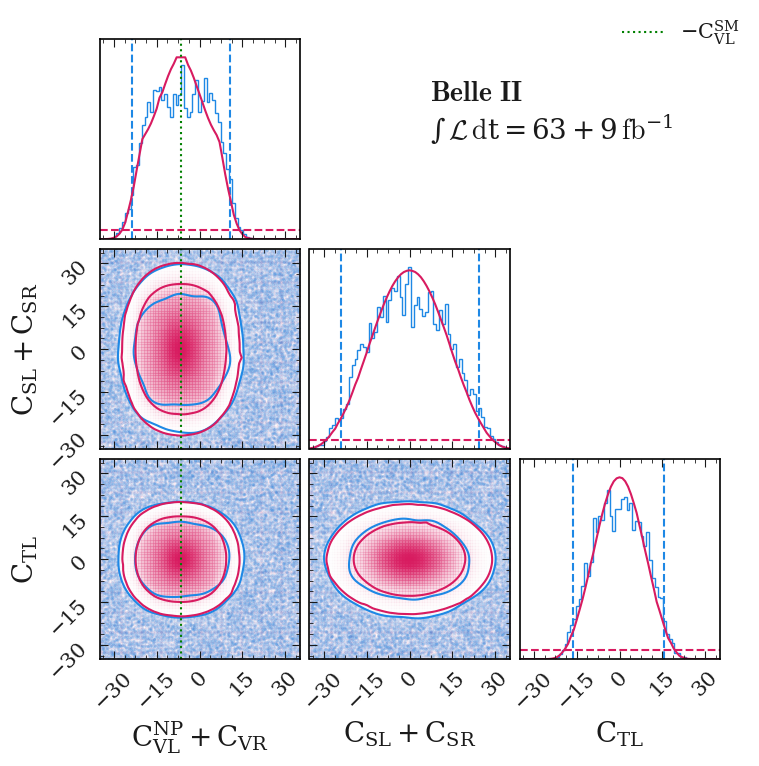

In [44]:
file = '../results/fit/WCscan/contour_overlay_corner.pdf'

fig = corner.corner(results['wilsons'], 
              bins=bins, 
              weights=ll_norm, 
              levels=(0.68, 0.95),
              quantiles=(0.025, 0.975), 
              smooth=3,
              labels=labels,
              color='#1E88E5',
              # show_titles=True,
              # title_kwargs={'fontsize':12}
              hist_kwargs = dict(density=True),
              );

fig = corner_cls.corner(results_cls['wilsons'], 
              bins=bins, 
              weights=results_cls['cls_obs'], 
              levels=(0.68, 0.95), 
              levels_1d=(0.95,), 
              range = [(-35, 35) for _ in range(3)],
              smooth=1,
              color='#D81B60',
              fig=fig
              );
plot.b2_logo(ax=fig.axes[1], x=0.6, fontsize=20)

corner_cls.overplot_lines(fig, [-cVLSM, None, None], color="g", linestyle='dotted', label=r'$-C_{VL}^{SM}$')

handles, labs = fig.axes[0].get_legend_handles_labels()
by_label = dict(zip(labs, handles))
fig.legend(by_label.values(), by_label.keys())

plt.savefig(file)  
plt.show()


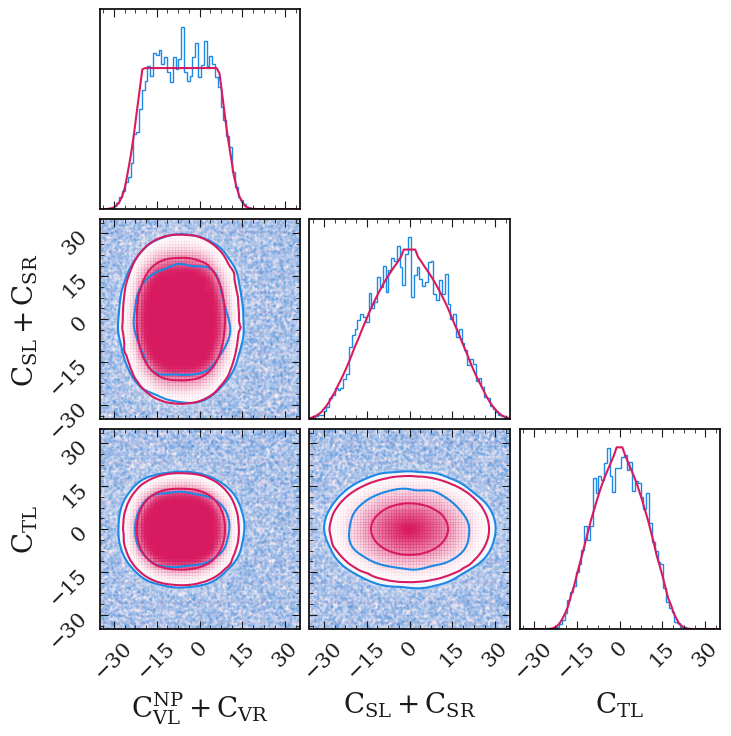

In [19]:
file = '../results/fit/WCscan/contour_overlay_corner.pdf'

fig = corner.corner(results['wilsons'], 
              bins=bins, 
              weights=ll_norm, 
              levels=(0.68, 0.95), 
            #   quantiles=(0.16, 0.84), 
              smooth=3,
              labels=labels,
              color='#1E88E5',
              # show_titles=True,
              # title_kwargs={'fontsize':12}
              hist_kwargs = dict(density=True),
              );

fig = corner_cls.corner(results_cls['wilsons'], 
              bins=bins, 
              weights=results_cls['tail_probs'][:,0], 
              levels=(0.68, 0.95), 
              # quantiles=(0.16, 0.84), 
              range = [(-35, 35) for _ in range(3)],
              smooth=1,
              color='#D81B60',
              fig=fig
              );
# plot.b2_logo(ax=fig.axes[2], fontsize=20)

# plt.savefig(file)  
plt.show()


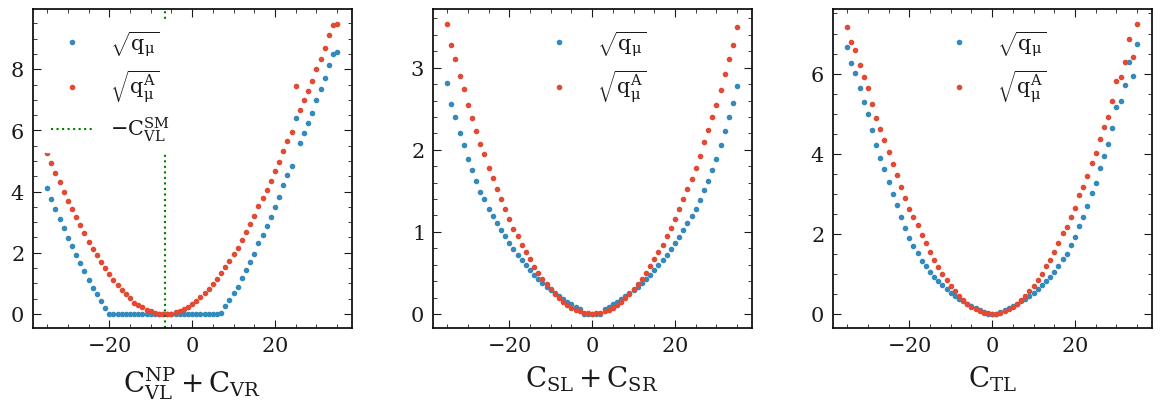

In [20]:
file = '../results/fit/WCscan/teststatistic.pdf'


fig, ax = plt.subplots(1,3,figsize=(12,4), constrained_layout=True)
cv = r'$C_{VL}^{NP} + C_{VR}$'
cs = r'$C_{SL} + C_{SR}$'
ct = r'$C_{TL}$'
labels = [cv, cs, ct]

for i in range(3):
    c = []
    qs = []
    for j, w in enumerate(results_cls['wilsons']):
        if ~np.isnan(w[i]) and np.isnan(w[(i+1)%3]) and np.isnan(w[(i+2)%3]):
            c.append(w[i])
            qs.append([results_cls['qmu'][j]+results_cls['qmuA'][j], results_cls['qmuA'][j]])
            
    ax[i].plot(c, qs, '.')
    ax[i].legend([r'$\sqrt{q_\mu}$', r'$\sqrt{q_\mu^A}$'])
    ax[i].set_xlabel(labels[i])
        
    ax[i].set_box_aspect(1)

ax[0].axvline(-cVLSM, color="g", linestyle='dotted', label=r'Standard Model')
ax[0].legend([r'$\sqrt{q_\mu}$', r'$\sqrt{q_\mu^A}$', r'$-C_{VL}^{SM}$'])

plt.savefig(file)  
plt.show()
